# IMDB

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [5]:
data_dir = Path(base_dir + 'data')
path = untar_data(URLs.IMDB_SAMPLE, dest=data_dir)
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb_sample/texts.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb_sample/data_save.pkl')]

It only contains one csv file, let's have a look at it.

In [6]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [7]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [9]:
data_lm.save()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [11]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [13]:
data.train_ds[0][0]

Text xxbos xxmaj this is another one of those ' humans vs insects / xxunk - horror ' features ; a theme that was popular in the late 70 's . xxmaj only you ca n't really call it horror . xxmaj there 's zero suspense and no gruesome events . xxmaj in other words : this movie is pretty lame . xxmaj it 's not that it 's really bad or something ; it 's just very boring . a construction site near a hotel uncovers a big nest of ants . xxmaj later on we learn that , probably due to different sorts of xxunk used in the past , their bite became xxunk . xxmaj some people get bitten and rushed to the hospital and it takes ages for the xxunk of the hospital to figure out what 's going on . xxmaj robert xxmaj xxunk figures it out first and then you can see him go berserk with a digging machine for what seems like several hours . xxmaj then they flee in the house , waiting to get rescued . xxmaj and , man , you should see all the efforts they make for rescuing them . i wo n't spoil too much , but at

But the underlying data is all numbers

In [14]:
data.train_ds[0][0].data[:10]

array([   2,    5,   21,   16,  186,   45,   14,  166,   69, 1509])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [16]:
path = untar_data(URLs.IMDB, dest=data_dir)
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/test'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/tmp_clas'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/README'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/unsup'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/train'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/tmp_lm'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/imdb.vocab')]

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=48

Now let's grab the full dataset for what follows.

In [18]:
(path/'train').ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/train/neg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/train/unsupBow.feat'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/train/pos'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [19]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [21]:
data_lm.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,"xxup dead , which makes you forget about its crap budget ) , and the acting is bad , bad , bad ( with the possible exception of the janitor ) . xxmaj in general the movie is boring , boring , boring . i ca n't think of a single scene that 's actually done well . xxmaj in fact , i disliked the movie so much i actually"
2,"and when the cops came to bust it up , they were butchered and eaten by the guests . i admit that it 's one of those movies where it 's so grotesque you simply ca n't look away , but this is by no means a creative work of art . xxmaj it 's pure shock value . \n \n xxmaj on the upside , it makes the"
3,". xxbos i gave this movie a rating of 1 because it is by far , the worst movie i 've ever seen in my life . xxmaj this movie was made in 2003 and i 've seen movies made in the 60 's with better special effects . i wish i could go into detail , but words ca n't describe how crappy this movie was . i could"
4,"and i have nightmares still over the miserable acting and the even more miserable jokes in this movie . xxmaj it 's so sad you xxup almost have to see it ... xxmaj but do n't . xxmaj the nightmares i have are far worse than any other nightmares you will ever have . xxmaj trust me ... i hate this movie so bad because of it 's acting ,"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


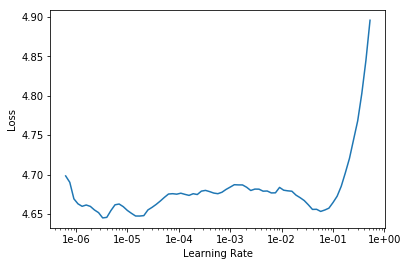

In [24]:
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.263124,4.088948,0.290181,1:29:23


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

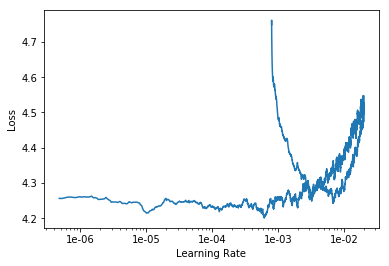

In [30]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(10, 1e-3/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.910383,3.871604,0.311198,1:39:47
1,3.836628,3.788881,0.321989,1:39:18


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))